# Disruption Lab x PowerBox Fa24 Demo

#### This notebook serves the same function as 'final_notebook.ipynb', but with non-essential code removed, easing time and memory usage on the scheduler.
For full code, graphs, and docs, see **'final_notebook.ipynb'**

#### Package Installations and Imports

In [16]:
%%capture
!pip install git+https://github.com/GoogleCloudPlatform/cloud-sql-python-connector.git
!pip install pystan
!pip install prophet
!pip install pg8000

In [35]:
from google.cloud import storage
import os

from sqlalchemy import create_engine, text
from google.cloud.sql.connector import Connector
import google.auth
import pandas as pd
from prophet import Prophet

import datetime
import matplotlib.pyplot as plt

#### Getting the Auth Key from Cloud Storage

In [36]:
def get_key():
    BUCKET_NAME = 'powerbox-test-438421-us-notebooks'
    KEY_PATH = 'key.json' # <BUCKET_NAME>/<KEY_PATH> on Cloud Storage

    LOCAL_PATH = "/tmp/key.json"  # Store the key in a temporary directory
    
    storage_client = storage.Client()
    bucket = storage_client.bucket(BUCKET_NAME)
    blob = bucket.blob(KEY_PATH)
    blob.download_to_filename(LOCAL_PATH)
    print(f"Downloaded service account key to {LOCAL_PATH}")

    # Set the GOOGLE_APPLICATION_CREDENTIALS environment variable
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = LOCAL_PATH

# Call this function before making any authenticated requests
get_key()

Downloaded service account key to /tmp/key.json


#### Connecting to the Database

In [37]:
DB_NAME="santa_ana_cc"
GCP_CONNECTION_NAME="demos-406119:us-central1:pbox-demo-replica"
GOOGLE_APPLICATION_CREDENTIALS= os.getenv("GOOGLE_APPLICATION_CREDENTIALS")
DB_USER="demo_user"
DB_PASS="0EtSv:{pn0hCCTKV"

def get_gcp_connector():
    connector = Connector()
    gcp_connector = connector.connect(
        GCP_CONNECTION_NAME,
        "pg8000",
        user=DB_USER,
        password=DB_PASS,
        db=DB_NAME,

    )
    return gcp_connector


# create an engine to the postgresql server, with no reference to the database
engine = create_engine("postgresql+pg8000://", creator=get_gcp_connector)
print(engine)

# Test the connection by running a simple query
def test_connection():
    try:
        with engine.connect() as connection:
            # Run a simple query
            result = connection.execute(text("SELECT NOW()"))
            # Fetch and print the result
            for row in result:
                print(f"Connected successfully. Current database time: {row[0]}")
    except Exception as e:
        print(f"Connection failed: {e}")

# Call the test function
test_connection()

Engine(postgresql+pg8000://)
Connected successfully. Current database time: 2024-12-18 23:25:21.029448+00:00


#### SQL Query Wrapper

In [38]:
# function that changes the SQL queries into a Pandas dataframe
def execute_pandas_query(query):
    try:
        with engine.connect() as connection:
            result = connection.execute(text(query))
            # Convert result to DataFrame
            if query.strip().upper().startswith("SELECT"):
                df = pd.DataFrame(result.fetchall(), columns=result.keys())
                return df
            else:
                print("Query executed successfully.")
                return None
    except Exception as e:
        print(f"Error occurred: {e}")
        return None

#### Example Query

In [39]:
query = 'SELECT real_power, timestamp FROM "super_meter_1.1" WHERE "timestamp" BETWEEN ' + "'2024-03-07'" + ' AND ' + "'2024-04-07'"
res = execute_pandas_query(query)
res.set_index('timestamp', inplace=True)
res

,real_power
timestamp,
2024-03-07 00:00:02.028179,37748.658
2024-03-07 00:00:08.706194,38080.832
2024-03-07 00:00:14.849997,37795.834
2024-03-07 00:00:21.199028,37807.625
2024-03-07 00:00:27.752682,37904.956000000006
...,...
2024-04-06 23:59:27.359311,29241.553
2024-04-06 23:59:34.118671,29422.07
2024-04-06 23:59:40.672097,30411.737


In [48]:
# Adjusting the resampling frequency to '1min' instead of every few seconds.
# This eases memory usage, speeding up forecasting predictions while maintaining accuracy.
new_res = res['real_power'].resample('1min').mean()
frame = { 'ds': new_res.index, 'y': new_res }
new_res = pd.DataFrame(frame)
new_res

,ds,y
timestamp,,
2024-03-07 00:00:00,2024-03-07 00:00:00,38046.247222
2024-03-07 00:01:00,2024-03-07 00:01:00,36955.9821
2024-03-07 00:02:00,2024-03-07 00:02:00,39485.751333
2024-03-07 00:03:00,2024-03-07 00:03:00,45291.2212
2024-03-07 00:04:00,2024-03-07 00:04:00,46260.942778
...,...,...
2024-04-06 23:55:00,2024-04-06 23:55:00,31779.259444
2024-04-06 23:56:00,2024-04-06 23:56:00,30109.302667
2024-04-06 23:57:00,2024-04-06 23:57:00,30029.300222


#### Forecasting

In [49]:
m = Prophet(changepoint_prior_scale=0.01).fit(new_res)

23:32:53 - cmdstanpy - INFO - Chain [1] start processing
23:33:02 - cmdstanpy - INFO - Chain [1] done processing


In [50]:
future = m.make_future_dataframe(periods=24*7, freq='h')
forecast = m.predict(future)

Text(0.5, 1.0, 'Real Power Forecasted Over Time')

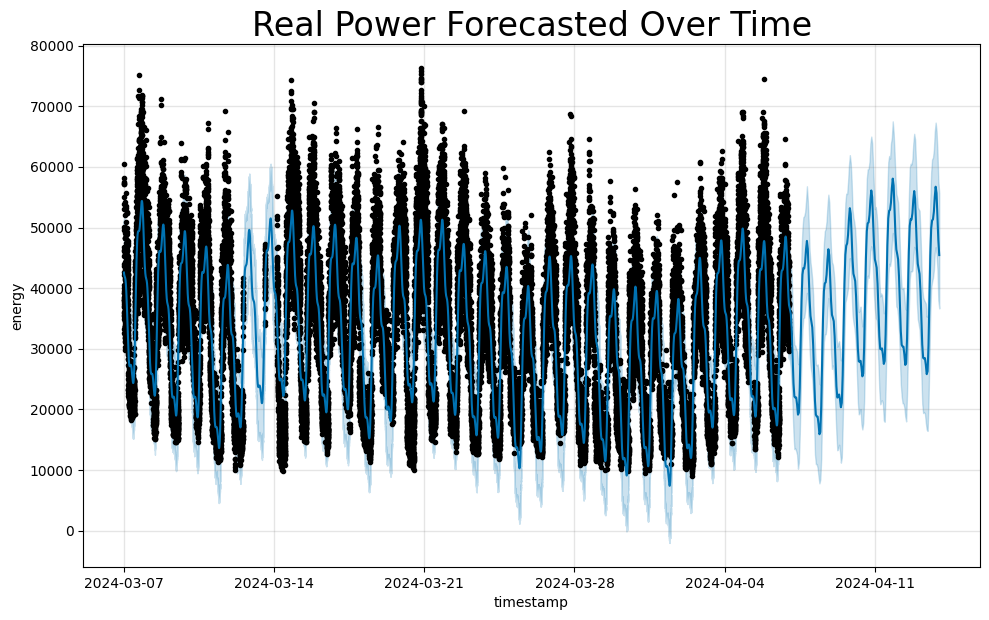

In [55]:
real_power_forecast = m.plot(forecast, xlabel = 'timestamp',ylabel = 'energy')
ax = real_power_forecast.gca()
ax.set_title("Real Power Forecasted Over Time", size=24)

#### Storage and Scheduling

In [56]:
# set up client and bucket
BUCKET_NAME = 'powerbox-test-438421-us-notebooks'
OUTPUT_PATH = 'scheduled_results_real' # output to <BUCKET_NAME>/<OUTPUT_PATH> in Cloud Storage

client = storage.Client()
bucket = client.bucket(BUCKET_NAME)

In [57]:
# generate a timestamp
timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H:%M:%S")
print(timestamp)

# create the output file with the timestamp
output_file = f"real_power_forecast_{timestamp}.png" # png
print(output_file)

# write plot to output_file
real_power_forecast.savefig(output_file) # real_power_forecast model calculated above

# save and upload to Cloud Storage
blob = bucket.blob(OUTPUT_PATH + "/" +  output_file) # store at <BUCKET_NAME>/<OUTPUT_PATH>/<output_file> in Cloud Storage
blob.upload_from_filename(output_file)
print(f"Uploaded {output_file} to {BUCKET_NAME}/{OUTPUT_PATH}")

# remove local output
os.remove(output_file)

2024_12_18_23:35:16
real_power_forecast_2024_12_18_23:35:16.png
Uploaded real_power_forecast_2024_12_18_23:35:16.png to powerbox-test-438421-us-notebooks/scheduled_results_real
